# EE 599 HW 5 Part 1: Quantization

Your task in this Colab notebook is to fill out the sections that are specified by **TODO** (please search the keyword `TODO` to make sure you do not miss any).

Prerequisites: set the runtime type to GPU. (Runtime -> Change Runtime Type)

## Initial Setup

This section imports all required packages from PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

Verify that GPU is availble to use.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Create CNN

Note: This section is similar to HW2.

Prepare CIFAR10 dataset.

In [3]:
# Set the batch size for data processing
batch_size = 4

# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (0.5, 0.5, 0.5)   # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert images to tensors
    transforms.Normalize(mean_values, std_values)  # Normalize tensor values
])

# Load the CIFAR10 training dataset and apply the defined transformations
trainset = torchvision.datasets.CIFAR10(root="./", train=True,
                                        download=True, transform=transform)

# Create a DataLoader to efficiently load and process training data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset and apply the same transformations as for training
testset = torchvision.datasets.CIFAR10(root="./", train=False,
                                       download=True, transform=transform)

# Create a DataLoader for test data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 96567613.29it/s] 


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Define a simple CNN that classifies CIFAR images.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the layers of the neural network architecture

        # First convolutional layer: 3 input channels, 6 output channels, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)

        # Max pooling layer with kernel size 2x2 and stride 2
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer: 6 input channels, 16 output channels, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)

        # Fully connected (dense) layers

        # First fully connected layer: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)

        # Second fully connected layer: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84, bias=False)

        # Third fully connected layer: 84 input features, 10 output features (for classification)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the neural network

        # Apply first convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # The output from the convolutional and pooling layers is in the form of a
        # 3D tensor (height, width, depth or channels).
        # To feed this tensor into a fully connected layer,
        # it needs to be flattened into a 1D tensor.
        # Reshape tensor for fully connected layers
        # A2D tensor with a shape of [batch_size, 16 * 5 * 5].
        x = x.view(-1, 16 * 5 * 5)

        # Apply first fully connected layer, followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply second fully connected layer, followed by ReLU activation
        x = F.relu(self.fc2(x))

        # Apply third fully connected layer (output layer)
        x = self.fc3(x)

        return x

# Create an instance of the neural network and move it to the specified device (e.g., GPU)
net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [5]:
def train(model: nn.Module, dataloader: DataLoader, epoch_num: int):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD optimizer with momentum

    for epoch in range(epoch_num):  # Loop over the dataset for multiple epochs
        running_loss = 0.0

        # Iterate over mini-batches of data
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)  # Move inputs to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            # Zero the gradients in the optimizer
            optimizer.zero_grad()

            # Forward pass + backward pass (backpropagation) + optimization
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')  # Training loop is complete

In [6]:
train(net, trainloader, 2)

[1,  2000] loss: 2.246
[1,  4000] loss: 1.936
[1,  6000] loss: 1.725
[1,  8000] loss: 1.611
[1, 10000] loss: 1.531
[1, 12000] loss: 1.513
[2,  2000] loss: 1.452
[2,  4000] loss: 1.443
[2,  6000] loss: 1.377
[2,  8000] loss: 1.389
[2, 10000] loss: 1.357
[2, 12000] loss: 1.349
Finished Training


Let us look at how the network performs on the test dataset.

In [7]:
# A function to evaluate the performance of a given neural network model
# using a test dataset.
# It calculates the accuracy of the model's predictions on the test data.
def calculate_accuracy(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0    # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

            if max_samples:  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[0]  # Increment the count of inferences made
                if inference_count > max_samples:  # Stop testing if maximum samples reached
                    break

    accuracy = 100 * correct_predictions / total_samples  # Calculate the accuracy as a percentage
    return accuracy

score = calculate_accuracy(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 52.09%


## Visualize Weights

Take each layer of our network and plot the historgram of its parameters.

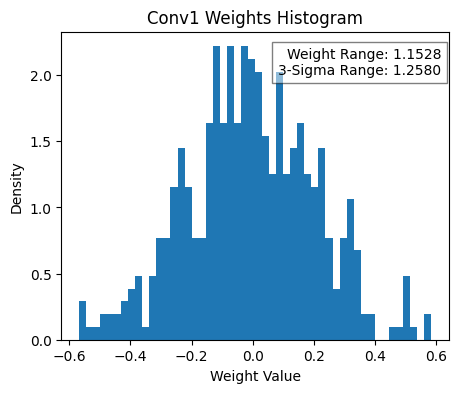

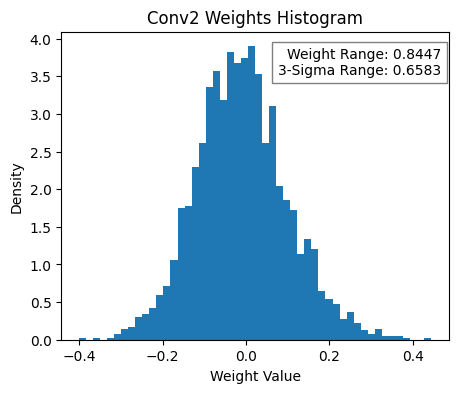

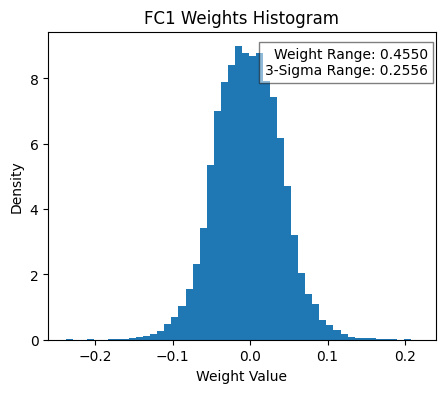

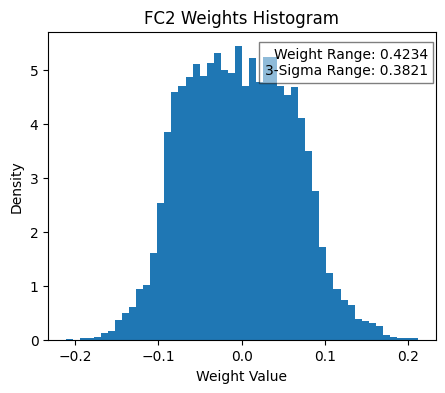

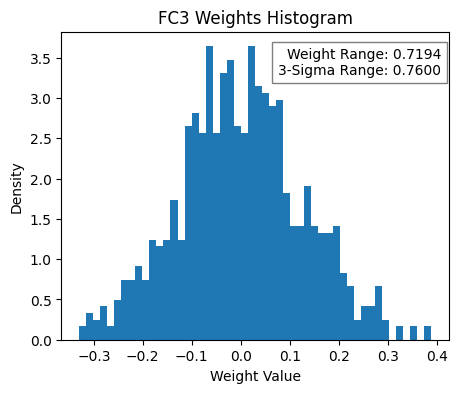

In [8]:
def analyze_layer_weights(layer_name: str, weight: torch.Tensor):
    # Extract and flatten the weights of the given layer
    layer_weights = weight.data.cpu().view(-1)

    plt.figure(figsize=(5, 4))

    # Plot a histogram of the flattened layer weights
    plt.hist(layer_weights, density=True, bins=50)
    plt.title(f"{layer_name} Weights Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")

    # Calculate the upper and lower bounds of the range within 3 standard deviations
    layer_weights_3sigma_max = (layer_weights.mean() + 3 * layer_weights.std()).item()
    layer_weights_3sigma_min = (layer_weights.mean() - 3 * layer_weights.std()).item()

    # Calculate the range of weights and the 3-sigma range for the layer
    weight_range = layer_weights.max() - layer_weights.min()
    sigma_range = layer_weights_3sigma_max - layer_weights_3sigma_min

    # Print weight range and 3-sigma range at the top right corner
    plt.text(0.98, 0.95, f'Weight Range: {weight_range.item():.4f}\n3-Sigma Range: {sigma_range:.4f}',
             horizontalalignment='right', verticalalignment='top',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

weight_data = [
    ("Conv1", net.conv1.weight),
    ("Conv2", net.conv2.weight),
    ("FC1", net.fc1.weight),
    ("FC2", net.fc2.weight),
    ("FC3", net.fc3.weight)
]

for name, weight in weight_data:
    analyze_layer_weights(name, weight)

### **TODO 1:**
Based on the plots shown above, does the 3-sigma range closely align with the overall range of the weights?

Your answer:
Yes, it does.

## Quantizing Weights

Remember that for matrix multiplication, we had:

$$\mathbf{y} = \mathbf{W}\mathbf{x}$$

If we only quantize weights, we would have the following:

$$\mathbf{y} = \mathbf{W^q}\mathbf{x}$$

In this section, we only quantize the weights and measure the accuracy.

## Deep copy the model

Take a look at the following function called `copy_model`, which is designed to create a deep copy of a model. This is particularly useful when we intend to modify the model multiple times and wish to preserve the original model without alterations.

In [9]:
from copy import deepcopy

def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

net_quan_w = copy_model(net)

### **TODO 2:**

Complete the following function, `quantized_weights` to quantize the weights.
This function should quantize the weights to 8-bit integers.

In [10]:
import torch
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    Use the 3-sigma range for determining the scaling factor.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    # TODO: Add your code here.
    # Calculate the upper and lower bounds of the range within 3 standard deviations
    layer_weights_3sigma_max = (weights.mean() + 3 * weights.std()).item()
    layer_weights_3sigma_min = (weights.mean() - 3 * weights.std()).item()

    sigma_range = layer_weights_3sigma_max - layer_weights_3sigma_min
    # print(sigma_range)

    scale = sigma_range / (127 - (-128))

    # Calculate full range but not good
    scale_full_range = abs(weights.max() - weight.min()) / (127 - (-128))
    # print(scale)

    quantized = torch.clip(torch.round(weights / scale), min=-128, max=127)

    return quantized, scale

We iterates through the each layer of the model and quantize its parameters.

In [11]:
def quantize_layer_weights(model: nn.Module):
    '''
    Quantizes the weights of Conv2d and Linear layers in a given PyTorch model.

    The function iterates through the children layers of the input model.
    For each Conv2d or Linear layer, it quantizes the weights to ensure
    that every value is an integer between -128 and 127. The scaling factor
    used for quantization is also stored as an attribute of the layer.

    Parameters:
    - model (nn.Module): The input PyTorch model whose weights need to be quantized.

    Raises:
    - Exception: If any quantized weight is out of the range [-128, 127].
    - Exception: If any quantized weight is not an integer.
    '''

    # Iterate through the children layers of the model
    for layer in model.children():

        # Check if the layer is a Conv2d or Linear layer
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):

            # Quantize the weights of the layer using the provided quantized_weights function
            # print(layer.weight[0])
            q_layer_data, scale = quantized_weights(layer.weight.data)

            # Move the quantized weights to the same device as the original data
            q_layer_data = q_layer_data.to(device)

            # Replace the original weights with the quantized weights
            layer.weight.data = q_layer_data

            # Store the scaling factor used for quantization as an attribute of the layer
            layer.weight.scale = scale

            # Check if any quantized weight is outside the range [-128, 127]
            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))

            # Check if any quantized weight is not an integer
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))


quantize_layer_weights(net_quan_w)

Calculate the accuracy

In [13]:
score = calculate_accuracy(net_quan_w, testloader)
print('Accuracy of the weight quantized model on the test images: {}%'.format(score))

Accuracy of the weight quantized model on the test images: 52.15%


## Visualize Activations

In PyTorch, a hook offers a way for users to inspect or adjust the model's internal computations without altering its original structure. The two primary types of hooks are:

1. Forward Hooks:
Used during the forward computational pass to access or adjust layer inputs/outputs.

2. Backward Hooks:
Engaged during the backward pass (during gradient computations) to access or modify gradients.

How to Use Hooks:
* Register the hook on a specific module using:
* `register_forward_hook` for forward hooks.
* `register_backward_hook` for backward hooks.
* The associated callback function will be triggered when the module processes data.
* Hooks serve as a potent tool in PyTorch, invaluable for tasks like debugging, visualization, and tailoring model behavior.

We use these hooks to store the activations in the network.

In [14]:
def append_activations(target_array, x):
    """
    Retrieve the activations from the first sample in the current batch (x[0]),
    transfer them to the CPU, and flatten the multi-dimensional tensor into a 1D array.
    Then, append this flattened array to the given target numpy array, which collects
    the activations for further analysis or storage.

    Parameters:
    - target_array: Existing numpy array where activations will be appended.
    - x: The PyTorch tensor representing the batch of activations.

    Returns:
    - Numpy array with the new activations appended.
    """
    return np.append(target_array, x[0].cpu().view(-1))


def register_activation_profiling_hooks(model: Net):
    """
    Registers hooks on specified layers of a given PyTorch model to profile and
    collect activations during the forward pass. These activations are stored
    directly on the layers as numpy arrays, facilitating tasks like analysis or debugging.

    The function sets an 'activations' attribute on each layer, which gets populated
    with activations as the model processes data.

    Parameters:
    - model (Net): The PyTorch model on which hooks are to be registered.
    """

    # List of layers to register hooks on
    layers = [model.conv1, model.conv2, model.fc1, model.fc2, model.fc3]


    # Register the input_hook to conv1.
    def input_hook(conv1_layer, x):
      """Special hook for input activations, which are captured before conv1"""
      model.input_activations = append_activations(model.input_activations, x)

    model.input_activations = np.empty(0)

    # The hook will be called every time before forward is invoked.
    model.conv1.register_forward_pre_hook(input_hook)

    # Register the hook for the output of each later.
    def generic_hook(layer, x, y):
      """
      A generic hook function designed to be registered with PyTorch layers.
      During the forward pass, it captures the activations from the input tensor,
      flattens them, and appends them to the layer's 'activations' attribute.

      Parameters:
      - layer: The PyTorch layer with which this hook is associated.
      - x: Input tensor to the layer.
      - y: Output tensor from the layer.
      """
      layer.activations = append_activations(layer.activations, y)


    for layer in layers:
        # Initialize an empty numpy array to store activations for each layer
        layer.activations = np.empty(0)

        # Register the generic hook for each layer
        layer.register_forward_hook(generic_hook)

Register activation profiling hooks and profile the input and output activations by running the model on test dataset again.

In [15]:
net_quan_a = copy_model(net)
register_activation_profiling_hooks(net_quan_a)

# Run through the test dataset again while profiling the input and output activations this time
score = calculate_accuracy(net_quan_a, testloader, max_samples=400)

Plot the activations of each layer and call it to create all the plots. Record any observations you make about the distribution of the values.

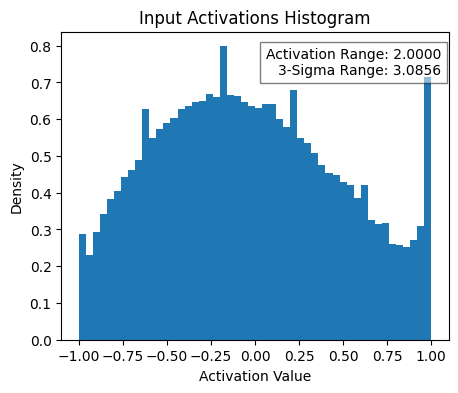

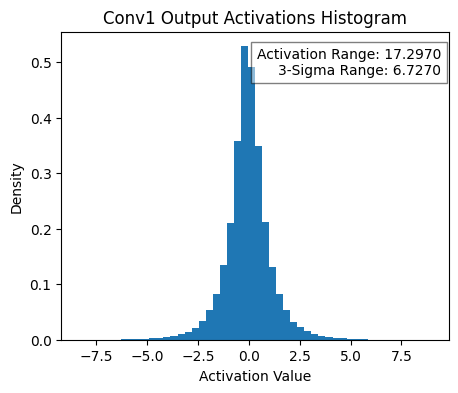

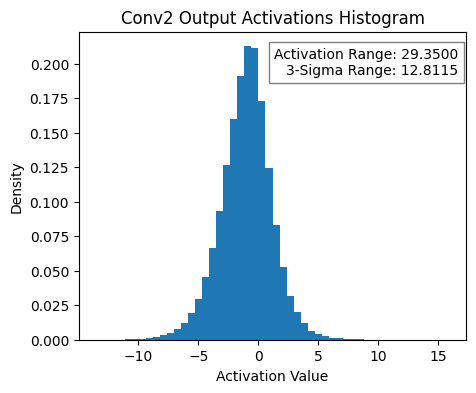

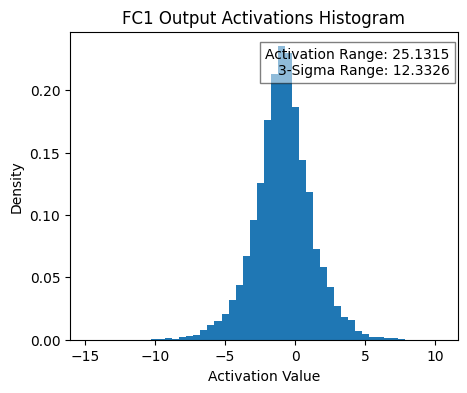

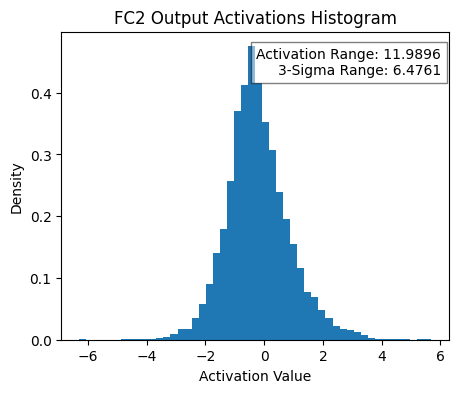

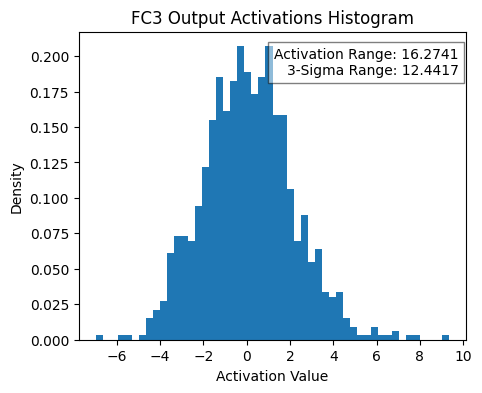

In [16]:
def analyze_input_activations(layer_name: str, activations: np.ndarray):
    """
    Analyze and plot the input activations.

    Parameters:
    - activations (np.ndarray): The activations to be analyzed.
    """

    # Flatten the activations for better visualization
    flattened_activations = activations.flatten()

    plt.figure(figsize=(5, 4))

    # Plot a histogram of the flattened activations
    plt.hist(flattened_activations, density=True, bins=50)
    plt.title(f"{layer_name} Activations Histogram")
    plt.xlabel("Activation Value")
    plt.ylabel("Density")

    # Calculate the upper and lower bounds of the range within 3 standard deviations
    activations_mean = np.mean(flattened_activations)
    activations_std = np.std(flattened_activations)
    activations_3sigma_max = activations_mean + 3 * activations_std
    activations_3sigma_min = activations_mean - 3 * activations_std

    # Calculate the range of activations and the 3-sigma range
    activations_range = np.max(flattened_activations) - np.min(flattened_activations)
    sigma_range = activations_3sigma_max - activations_3sigma_min

    # print(f"Input Activations Range: {activations_range}")
    # print(f"Input Activations 3-Sigma Range: {sigma_range}")

    plt.text(0.98, 0.95, f'Activation Range: {activations_range:.4f}\n3-Sigma Range: {sigma_range:.4f}',
            horizontalalignment='right', verticalalignment='top',
            transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


# List of (name, activations) tuples
activation_data = [
    ("Input", net_quan_a.input_activations),
    ("Conv1 Output", net_quan_a.conv1.activations),
    ("Conv2 Output", net_quan_a.conv2.activations),
    ("FC1 Output", net_quan_a.fc1.activations),
    ("FC2 Output", net_quan_a.fc2.activations),
    ("FC3 Output", net_quan_a.fc3.activations)
]

# Loop through each (name, activations) tuple and call the analysis function
for name, activations in activation_data:
    analyze_input_activations(name, activations)

### **TODO 3:**

Based on the plots observed above, does the 3-sigma range closely align with the overall range of the activation?

Your answer: No, it does not.

## Quantizing Activations

Before performing any quantization let's describe the output of the `conv1` layer as:

$$ W_{conv1} * In = Out_{conv1} $$

Suppose:
- We scale the input, $ In $, scaling it by $ s_{In} $.
- We scale the weight, $ W_{conv1} $, by $ s_{W_{conv1}} $
- We scale output, $ Out_{conv1} $, by $ s_{Out_{conv1}} $.


### **TODO 4:**

Now try to answer the following questions:

1. Calculate $ s_{Out_{conv1}}$ and the quantized output of `conv1` layer, $Out_{conv1}^{q}$.

2. Calculate $ s_{Out_{conv2}}$ and the quantized output of `conv2` layer, $Out_{conv2}^{q}$.

3. How would you generalize the output scale calculation to the next layers?


Assume no pooling or relu exists.

Your answer:  
1. $ s_{Out_{conv1}} $ = ($ Out_{max} $  -  $ Out_{min} $) / ($ 2^q - 1 $)    
   $ Out_{conv1}^{q} $ = ($ W_{conv1} $  *  $ In $) / ($ s_{Out_{conv1}} $ * $
   s_{in} $ * $ s_{W_{conv1}} $)  
2. $ s_{Out_{conv2}} $ = ($ Out_{2_{max}} $  -  $ Out_{2_{min}} $) / ($ 2^q - 1 $)    
   $ Out_{conv2}^{q} $ = ($ W_{conv2} $ * $ W_{conv1} $  *  $ In $) / ($ s_{Out_{conv2}} $ * $ s_{Out_{conv1}} $ * $ s_{in} $ * $ s_{W_{conv1}} $ * $ s_{W_{conv2}} $)  
3. $ s_{Out_{conv_n}} $ = ($Out_{n_{max}}$ - $Out_{n_{min}}$) / ($ 2^q $ - 1)   
   $$
   Out_{conv_n}^{q} = \left( \prod_{i=1}^{n} W_{conv_i} \right) \cdot In / \left( s_{In} \cdot \prod_{i=1}^{n} s_{W_{conv_i}} \cdot s_{Out_{conv_n}} \right)
   $$



Now we are going to implement a network where both weights and activations are quantized.

### **TODO 5:**
Complete these functions in the following code:
1. Understand what the `__init__` function is doing, but it should stay unchanged.
2. Complete `quantize_initial_input`.
3. Complete `quantize_activations`.
4. Write the `forward` function of this quantized network, similar to the original net's `forward` function, but make sure you use `round` and clip the values.


In [51]:
from typing import List


# Used in the next section
def nearest_power_of_two(n):
    return 2**round(np.log2(n))


class NetQuantized(nn.Module):
    """
    A PyTorch neural network model with quantized weights and activations.

    This class is designed to create a quantized version of a neural network, where both
    weights and activations are quantized to a limited range of values. It also provides
    methods for quantization and scaling of input data and activations.

    Note that NetQuantized is inherited from nn.Module.

    Attributes:
    - conv1 (nn.Module): The first convolutional layer.
    - pool (nn.Module): The pooling layer.
    - conv2 (nn.Module): The second convolutional layer.
    - fc1 (nn.Module): The first fully connected layer.
    - fc2 (nn.Module): The second fully connected layer.
    - fc3 (nn.Module): The third fully connected layer.

    Methods:
    - quantize_initial_input(pixels: np.ndarray) -> float: Calculate a scaling factor for the initial input.
    - quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> float: Calculate scaling factor for layer output.
    - forward(x: torch.Tensor) -> torch.Tensor: Forward pass through the quantized network.

    Usage:
    Initialize an instance of this class with a quantized neural network model,
    and it will automatically set up quantization and scaling for both input and activations.
    """

    def __init__(self, net_with_weights_quantized: nn.Module):
      """
      Initialize a quantized neural network model.

      Parameters:
      - net_with_weights_quantized (nn.Module): The input PyTorch model with quantized weights.

      This class is designed to create a quantized version of a neural network, where both
      weights and activations are quantized to a limited range of values.
      """
      super(NetQuantized, self).__init__()

      # Create a copy of the input model to avoid modifying the original model
      net_init = copy_model(net_with_weights_quantized)

      self.conv1 = net_init.conv1
      self.pool = net_init.pool
      self.conv2 = net_init.conv2
      self.fc1 = net_init.fc1
      self.fc2 = net_init.fc2
      self.fc3 = net_init.fc3

      # Define a list of layers to use throughout the model
      layers = [self.conv1, self.conv2, self.fc1, self.fc2, self.fc3]

      # Register pre-hooks for each layer to check input data before forward pass
      for layer in layers:
          def pre_hook(l, x):
              x = x[0]  # Extract the input tensor from the tuple
              # Check if input values are within the range for an 8-bit signed integer
              if (x < -128).any() or (x > 127).any():
                  raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
              # Check if input values have fractional parts (i.e., they are not integers)
              if (x != x.round()).any():
                  raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

          layer.register_forward_pre_hook(pre_hook)

      # Calculate the scaling factor for the initial input to the CNN
      self.input_activations = net_with_weights_quantized.input_activations
      self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

      # Calculate the output scaling factors for all the layers of the CNN
      preceding_layer_scales = []
      for layer in layers:
          layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
          # Store the scales for later use in subsequent layers
          print(layer.output_scale)
          preceding_layer_scales.append((layer.weight.scale, layer.output_scale))


    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # TODO: Add your code here.
        # Scaling factor for 8-bit integer
        # scale_factor = abs(pixels.max() - pixels.min()) / (127 - (-128))
        # Scaling factor for 4-bit integer
        scale_factor = abs(pixels.max() - pixels.min()) / (15)

        return scale_factor


    @staticmethod
    def quantize_activations(activations: np.ndarray, s_w: float, s_initial_input: float, weight_output_scales: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        s_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        s_initial_input (float): The scale by which the initial input to the neural network was multiplied
        weight_output_scales ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''
        # TODO: Add your code here.
        combined_scale = s_w * s_initial_input
        for scale in weight_output_scales:
            if scale[0] !=0 or scale[1] !=0:
              combined_scale *= scale[0] * scale[1]

        # Scaling factor for 8-bit integer
        activation_scale = abs(activations / combined_scale).max() / (127)
        # Scaling factor for 4-bit integer
        # activation_scale = abs(activations / combined_scale).max() / (15)

        # For TODO6
        # activation_scale = nearest_power_of_two(activation_scale)

        return activation_scale


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Add your code here.
        # Apply initial input scaling
        # print(x)
        x = torch.clip(torch.round(x / self.input_scale), min=-128, max=127)
        # print(x)

        x = F.relu(self.conv1(x))
        x = x / self.conv1.output_scale
        x = self.pool(x)
        x = torch.clip(torch.round(x), min=-128, max=127)
        # print(x)

        x = F.relu(self.conv2(x))
        x = x / self.conv2.output_scale
        x = self.pool(x)
        x = torch.clip(torch.round(x), min=-128, max=127)

        x = x.view(-1, 16 * 5 * 5)

        x = F.relu(self.fc1(x))
        x = x / self.fc1.output_scale
        x = torch.clip(torch.round(x), min=-128, max=127)

        x = F.relu(self.fc2(x))
        x = x / self.fc2.output_scale
        # print(x)
        x = torch.clip(torch.round(x), min=-128, max=127)

        # print(x)
        x = self.fc3(x)
        x = x / self.fc3.output_scale
        # x = torch.clip(torch.round(x), min=-128, max=127)

        return x

In [52]:
# Merge the information from net_quan_w and net_quan_a together
net_init = copy_model(net_quan_w)
net_init.input_activations = deepcopy(net_quan_a.input_activations)
for layer_init, layer_quan_a in zip(net_init.children(), net_quan_a.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_quan_a.activations)

net_quantized = NetQuantized(net_init)

107.23242834563534
685.3298396685075
931.6742291362344
284.3172188945316
496.2759703949139


Calculate the accuracy

In [53]:
score = calculate_accuracy(net_quantized, testloader)
print('Accuracy of the weight and activation quantized net on the test images: {}%'.format(score))

Accuracy of the weight and activation quantized net on the test images: 51.95%


### **TODO 6:**

1. Write down the scaling factors you calculated in the previous section for each layer. Instead of reporting the scale factor itself, $s$, report $\frac{1}{s}$ for each layer.
2. Modify the network so that you round each $\frac{1}{s}$ for activations to the nearest power of 2 and use that instead. For example, if $\frac{1}{s} = 230.46005$, round it to $256$
    - What is the benefit of this approximation?
    - Recalculate the accuracy.
3. Instead of 8-bit integers, modify your code to use 4-bit integers. Recalculate the accuracy.

Your answer:

1. The scaling factors are:   
   In 1/s format:   
   conv1: 1822.951281875801   
   conv2: 685.3298396685074   
   fc1: 931.6742291362344   
   fc2: 284.31721889453166   
   fc3: 496.27597039491394   
2. The benefit is that rounding to the nearest power of 2 simplifies the hardware implementation of the quantization and dequantization processes. Multiplication by a power of 2 can be efficiently implemented as a bit shift operation, which is faster and consumes less power than general multiplication.   
   Accuracy of the model with rounded scaling factors on the test images is 52.14%, which is a little bit highier than the unrounded one.
3. Accuracy of the 4-bit integer scaling factor is: 51.25%